In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
%matplotlib inline

In [2]:
forecast = pd.read_csv('forecastNash.csv', parse_dates=['endTime', 'startTime', 'retrievalDate'])
hourly_forecast = pd.read_csv('hourlyForecastNash.csv', parse_dates=['endTime', 'startTime', 'retrievalDate'])
observations = pd.read_csv('observedWeatherNash.csv', parse_dates=['retrievalDate', 'dateTime'])

In [3]:
forecast['retrievalDate'].nunique()

58

In [4]:
# labeling the day number as the forecast day
number2day = {1:'day1', 2:'night1', 3:'day2', 4:'night2', 5:'day3', 6:'night3', 7:'day4', 8:'night4', 
              9:'day5', 10:'night5', 11:'day6', 12:'night6', 13:'day7', 14:'night7'}

forecast['forecastDay'] = forecast['number'].map(number2day)

# Extract numerical rainfall amount forecast

The forecast rainfall amount is written out as text in the detailedForecast column. I need to extract it from each forecast where it is listed. When a range is given, I put the low and high estimates in their own columns. When no range is given, the amount listed is put in the high column, and zero in the low column.

In [5]:
# extract numerical rainfall amount forecast and assign them to low and high

rainList = ['tenth', 'quarter ', 'half', 'three', 'one', '1', '2']
rainValue = [0.1, 0.25, 0.5, 0.75, 1, 1, 2]

low = []
high = []

for text in forecast['detailedForecast']:
    if 'New rainfall amounts' in text:
        out = text.split('.')
        if 'less than' in text:
            high.append(0.0)
            low.append(0.1)
        elif 'between' in text:
            textSplit = out[-2].split('and')
            for i in range(len(rainList)):
                if rainList[i] in textSplit[0]:
                    low.append(rainValue[i])
                if rainList[i] in textSplit[1]:
                    high.append(rainValue[i])
    else:
        high.append(0.0)
        low.append(0.0)

# Add rainfall amount forecasts to columns in the forecast DataFrame

forecast['rain low'] = low
forecast['rain high'] = high

# Fixing mislabeled dates

Some of the dates in the forecast data are incorrect. I can fix them because I know what date I retrieved the data, so I can use the relative date they are at and the forecast number. The startTime can then be fixed by subtracting 12 hours from the endTime.

In [6]:
# Dictionary to encode the forecast number to the number of days after the forecast is retrieved
dateOffsetDict = {1:0, 2:1, 3:1, 4:2, 5:2, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:6, 13:6, 14:7}

forecast['value'] = forecast['number'].map(dateOffsetDict)

newTime = []
for index, row in forecast.iterrows():
    # Difference between  endDate and retrievalDate
    t = row['endTime'].date() - row['retrievalDate'].date()
    # Offset from endTime
    offset = (row['value'] - t.days)
    newTime.append(row['endTime'] + timedelta(days=offset))
    
forecast['endTime'] = newTime

# Calculate corrected startTime
forecast['startTime'] = forecast['endTime'] - timedelta(hours=12)

In [7]:
dayForecast = forecast[forecast['isDaytime']]
nightForecast = forecast[~forecast['isDaytime']]

# working with the observed data

In [8]:
# Extract the wind speed and direction from text
observations[['windDir', 'windSpeed']] = observations['Wind(mph)'].str.split(n=1, expand=True)
observations['windSpeed'] = observations['windSpeed'].str.split(n=1).str[0]
observations['windSpeed'] = pd.to_numeric(observations['windSpeed'])

# Sort the observations in ascending order
observations.sort_values('dateTime', inplace=True)

In [9]:
shortObs = observations[['dateTime', 'retrievalDate', 'AirTemp', 'Dwpt', 'WindChill(°F)', 'HeatIndex(°F)', 
                         '1hrPrecip', 'windDir', 'windSpeed']]

Get the observations over the same time range as the daytime and nighttime forecasts. Need the maximum and minimum values of temperature, dewpoint, heat index, and windspeed for the daytime and nighttime observations, respectively. Need the sum of the observed precipitation and the most common wind direction for both the daytime and nighttime observations.

In [10]:
dayObs = []
nightObs = []

for i in range(len(dayForecast['startTime'].unique()[:-7])):
    # get observations for the same datetime range as the daytime forecasts
    temp = (shortObs[(shortObs['dateTime'] > dayForecast['startTime'].unique()[i]) & 
                     (shortObs['dateTime'] < dayForecast['endTime'].unique()[i])])
    dayObs.append({
        'startTime': dayForecast['startTime'].unique()[i],
        'endTime': dayForecast['endTime'].unique()[i],
        'AirTemp_obs': temp['AirTemp'].max(),
        'Dwpt_obs': temp['Dwpt'].max(),
        'HeatIndex_obs': temp['HeatIndex(°F)'].max(),
        'Precip_obs': temp['1hrPrecip'].sum(),
        'windDir_obs': temp['windDir'].value_counts().idxmax(),
        'windSpeed_obs': temp['windSpeed'].max()
    }
    )
    
    # get observations for the same datetime range as the nighttime forecasts
    temp1 = (shortObs[(shortObs['dateTime'] > nightForecast['startTime'].unique()[i]) & 
                     (shortObs['dateTime'] < nightForecast['endTime'].unique()[i])])
    nightObs.append({
        'startTime': nightForecast['startTime'].unique()[i],
        'endTime': nightForecast['endTime'].unique()[i],
        'AirTemp_obs': temp1['AirTemp'].min(),
        'Dwpt_obs': temp1['Dwpt'].min(),
        'HeatIndex_obs': temp1['HeatIndex(°F)'].min(),
        'Precip_obs': temp1['1hrPrecip'].sum(),
        'windDir_obs': temp1['windDir'].value_counts().idxmax(),
        'windSpeed_obs': temp1['windSpeed'].max()
    }
    )
    
dayObs = pd.DataFrame(dayObs)
nightObs = pd.DataFrame(nightObs)

allObs = pd.concat([dayObs, nightObs], ignore_index=True)
forecast_obs = pd.merge(left=forecast, right=allObs, on=['startTime', 'endTime'], how='left')

In [11]:
# Difference between the forecast and observations:
forecast_obs['tempDiff'] = forecast_obs['temperature'] - forecast_obs['AirTemp_obs']
forecast_obs['rainLowDiff'] = forecast_obs['rain low'] - forecast_obs['Precip_obs']
forecast_obs['rainHighDiff'] = forecast_obs['rain high'] - forecast_obs['Precip_obs']
forecast_obs['windLowDiff'] = forecast_obs['windSpeedMin'] - forecast_obs['windSpeed_obs']
forecast_obs['windHighDiff'] = forecast_obs['windSpeedMax'] - forecast_obs['windSpeed_obs']
# boolean column to mark whether it rained or not
forecast_obs['rain?'] = (forecast_obs['Precip_obs'] > 0)

In [12]:
# Get DataFrames for each forecast day/night

day1 = forecast_obs[forecast_obs['number'] == 1]
night1 = forecast_obs[forecast_obs['number'] == 2]
day2 = forecast_obs[forecast_obs['number'] == 3]
night2 = forecast_obs[forecast_obs['number'] == 4]
day3 = forecast_obs[forecast_obs['number'] == 5]
night3 = forecast_obs[forecast_obs['number'] == 6]
day4 = forecast_obs[forecast_obs['number'] == 7]
night4 = forecast_obs[forecast_obs['number'] == 8]
day5 = forecast_obs[forecast_obs['number'] == 9]
night5 = forecast_obs[forecast_obs['number'] == 10]
day6 = forecast_obs[forecast_obs['number'] == 11]
night6 = forecast_obs[forecast_obs['number'] == 12]
day7 = forecast_obs[forecast_obs['number'] == 13]
night7 = forecast_obs[forecast_obs['number'] == 14]

Plotting function to compare the forecast to the observations.

In [13]:
def plotForecast(df, variable='temperature'):
    """Plots temperature observations and forecasts bot in absolute measurements and relative to the 
    observations to show the differences.
    
    Args:
        df: DataFrame that contains data to plot from
        variable(str, optional): weather parameter to plot. Available options: 'temperature' (default), 
            'rainHigh', 'rainLow', 'windLow', and 'windHigh'.
    """
    # dictionary with list of column names needed to plot each type of weather data
    var = {'temperature': ['temperature', 'AirTemp_obs', 'tempDiff', 'Temperature (Farenheit)'], 
           'rainHigh': ['rain high', 'Precip_obs', 'rainHighDiff', 'Precipitation (inches)'], 
          'rainLow': ['rain low', 'Precip_obs', 'rainLowDiff', 'Precipitation (inches)'], 
          'windLow': ['windSpeedMin', 'windSpeed_obs', 'windLowDiff', 'Wind Speed (mph)'], 
          'windHigh': ['windSpeedMax', 'windSpeed_obs', 'windHighDiff', 'Wind Speed (mph)']}
    
    plt.subplots(figsize=(16,6))
    # forecast plot
    plt.subplot(1,2,1)
    plt.plot(df['endTime'], df[var[variable][1]], label='observed')
    plt.plot(df['endTime'], df[var[variable][0]], marker='o', linestyle='None', label='forecast')
    plt.xlabel('date')
    plt.ylabel(var[variable][3])
    plt.xticks(rotation=90)
    plt.title(df['forecastDay'].iloc[0] + ' forecast')
    plt.legend()
    
    # forecast difference plot
    plt.subplot(1,2,2)
    plt.plot(df['endTime'], (df[var[variable][1]] - df[var[variable][1]]), label='observed')
    plt.plot(df['endTime'], (df[var[variable][2]]), marker='o', linestyle='None', label='forecast')
    plt.xlabel('date')
    plt.ylabel(variable + ' difference\n (forecast/observed)')
    plt.xticks(rotation=90)
    plt.title(df['forecastDay'].iloc[0] + ' forecast difference')
    plt.legend();
    plt.show()

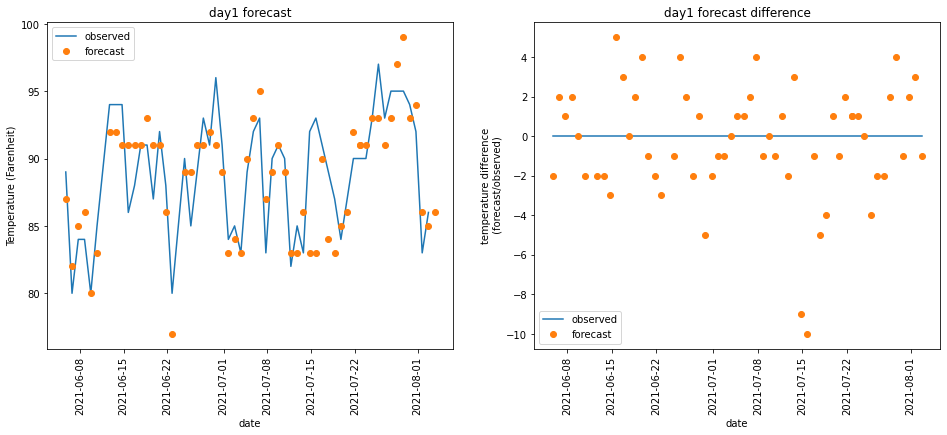

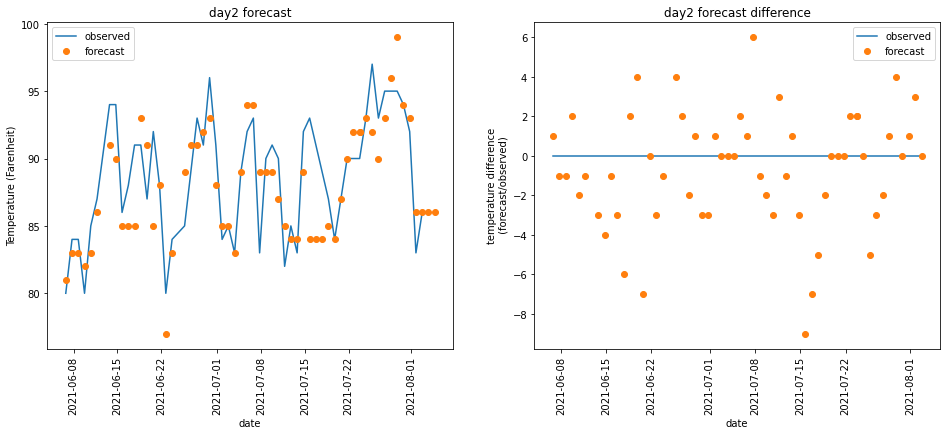

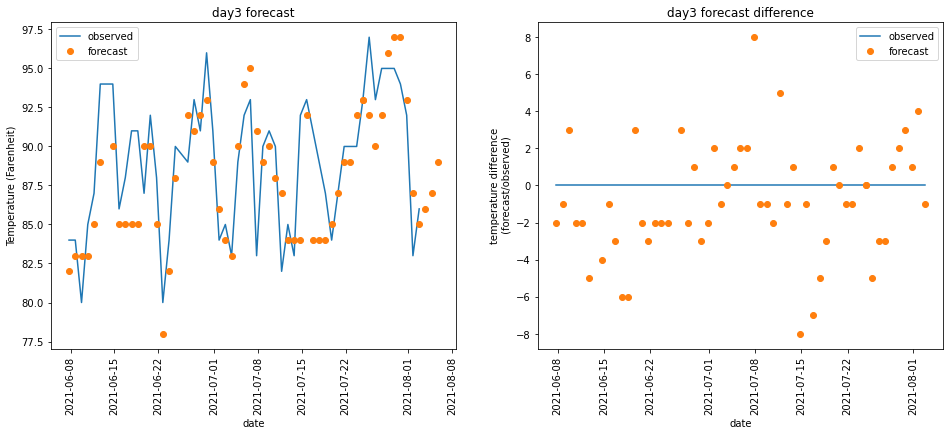

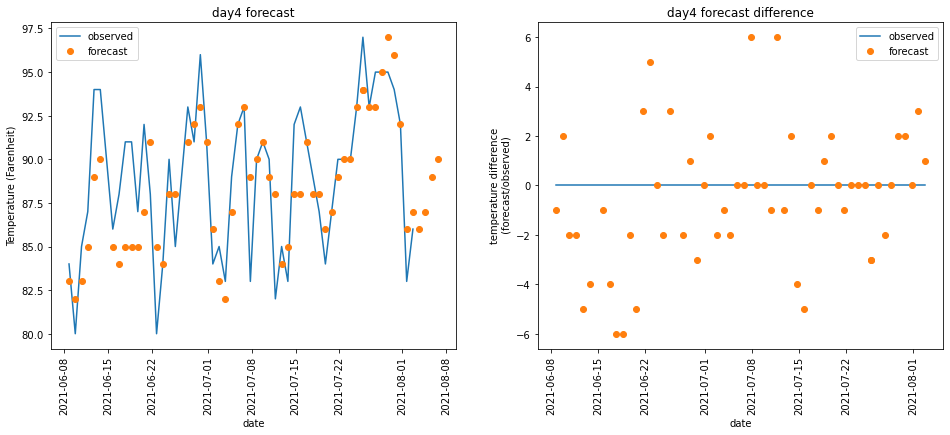

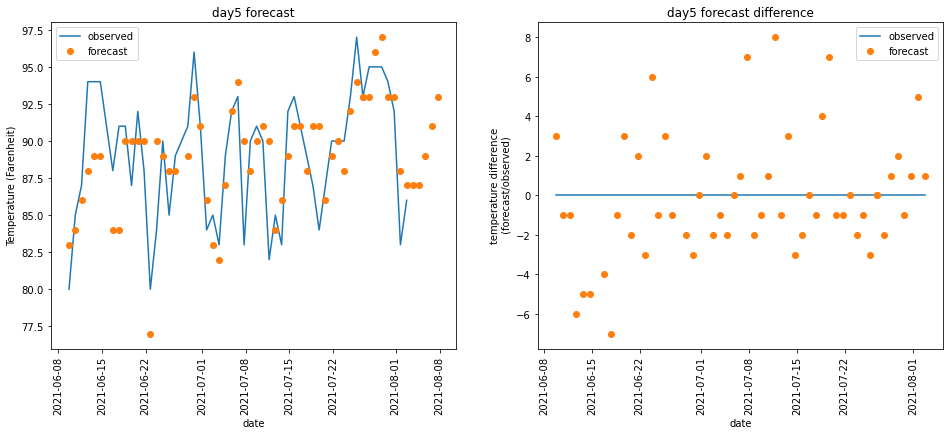

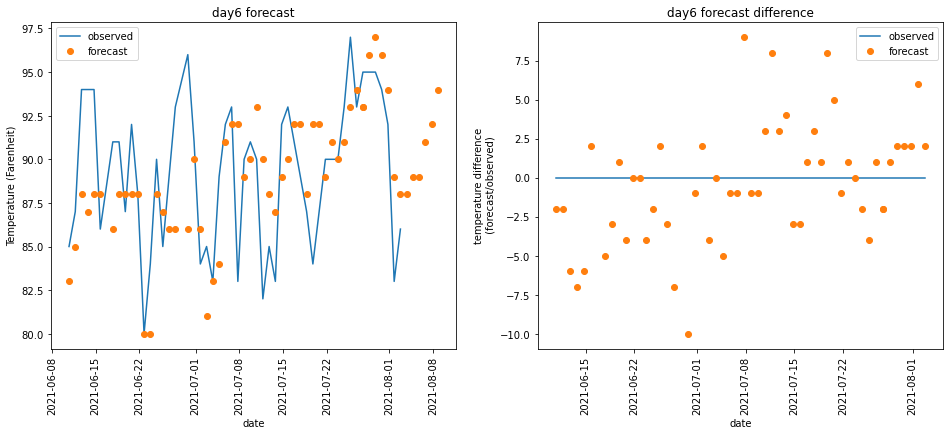

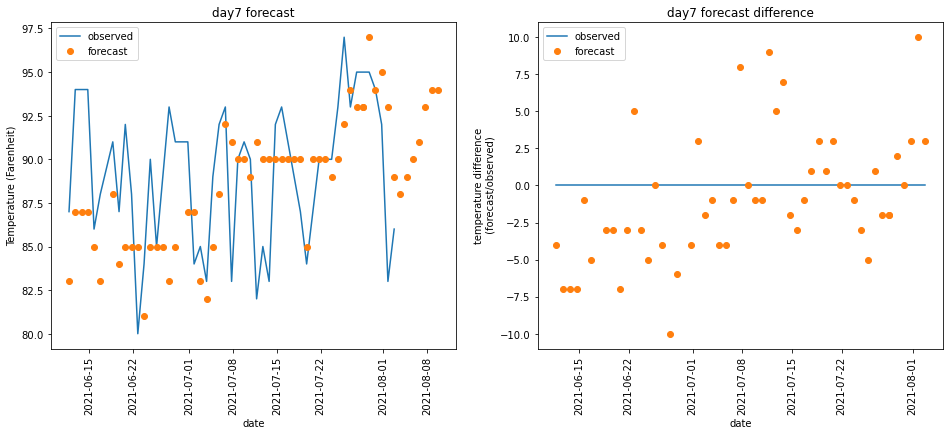

In [14]:
dayList = [day1, day2, day3, day4, day5, day6, day7]

for day in dayList:
    plotForecast(day)

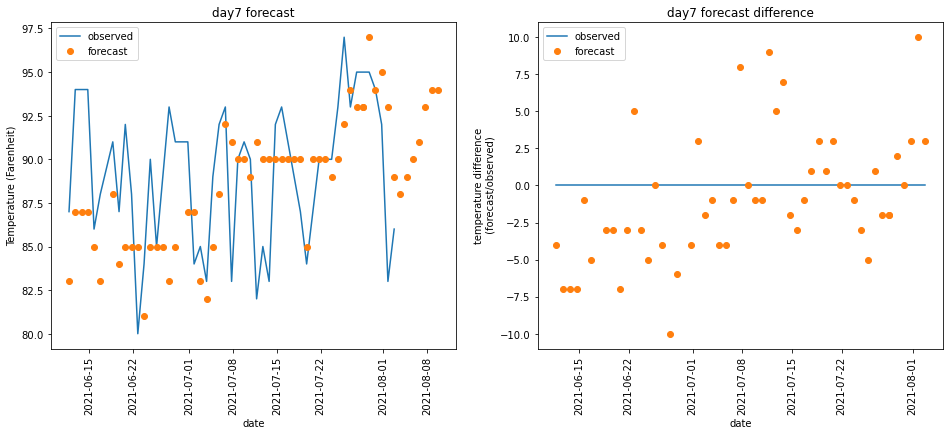

In [15]:
plotForecast(day7)

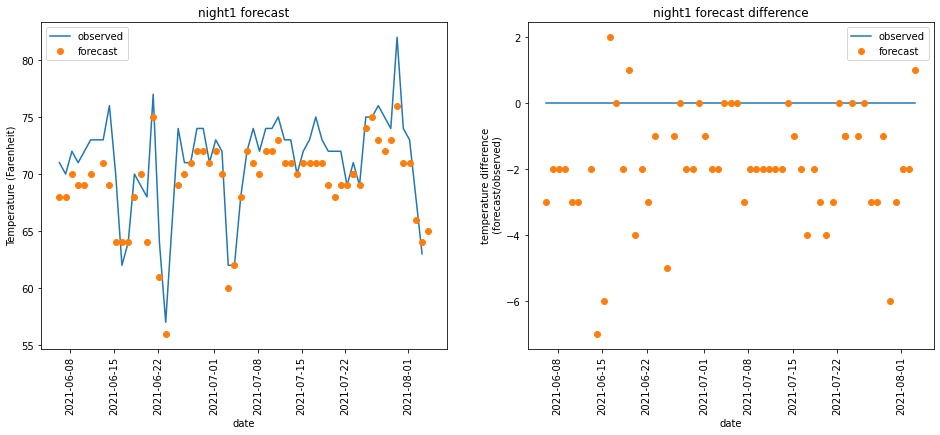

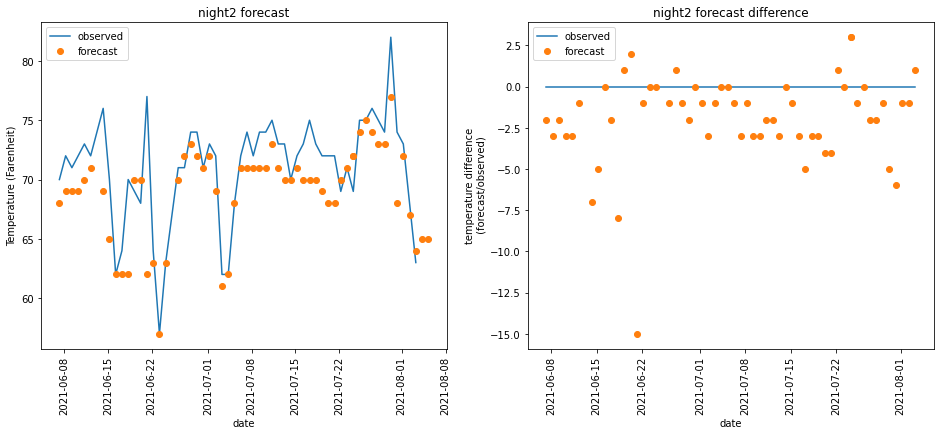

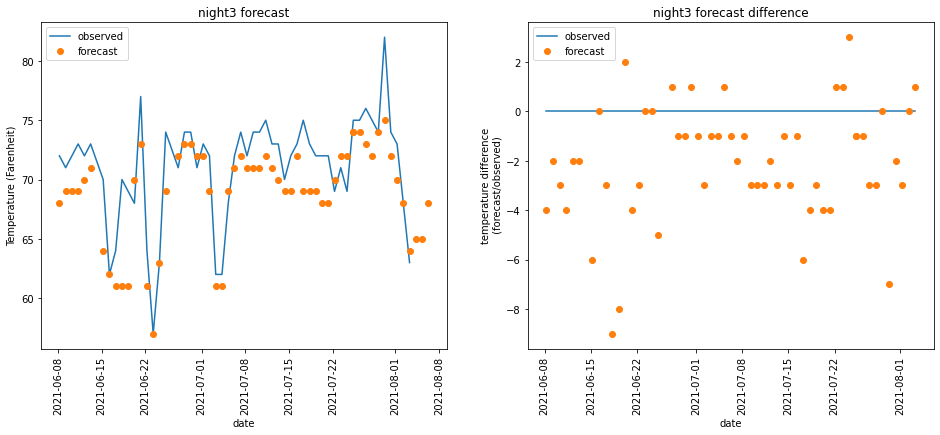

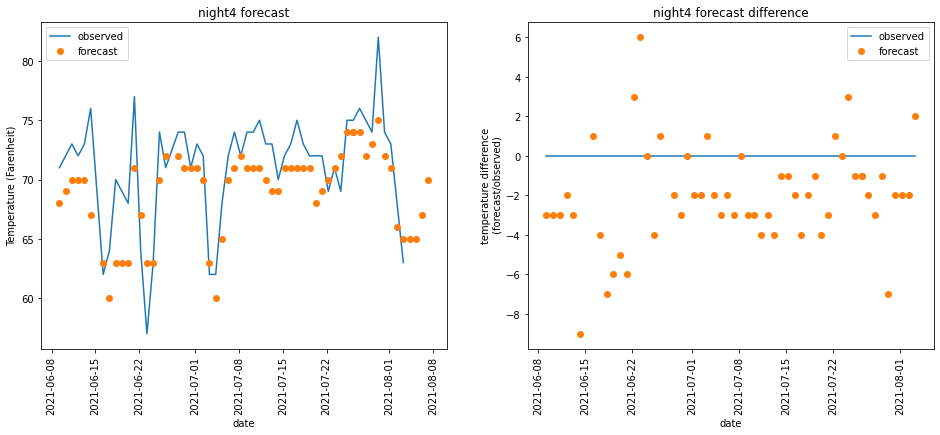

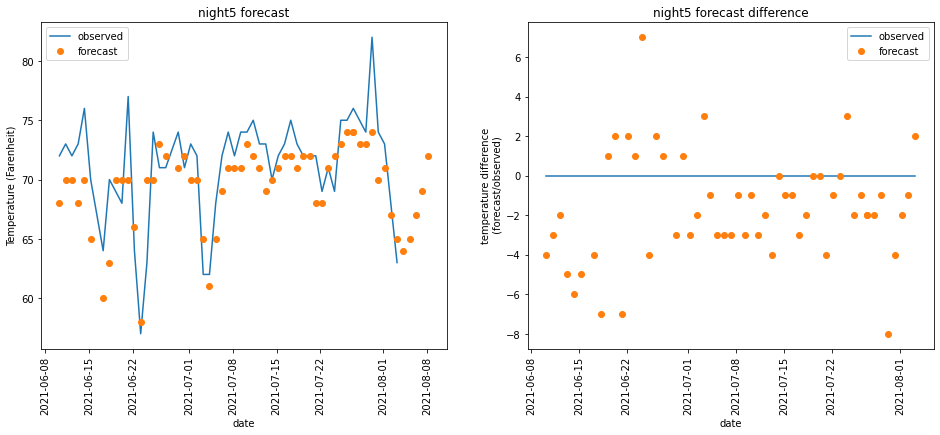

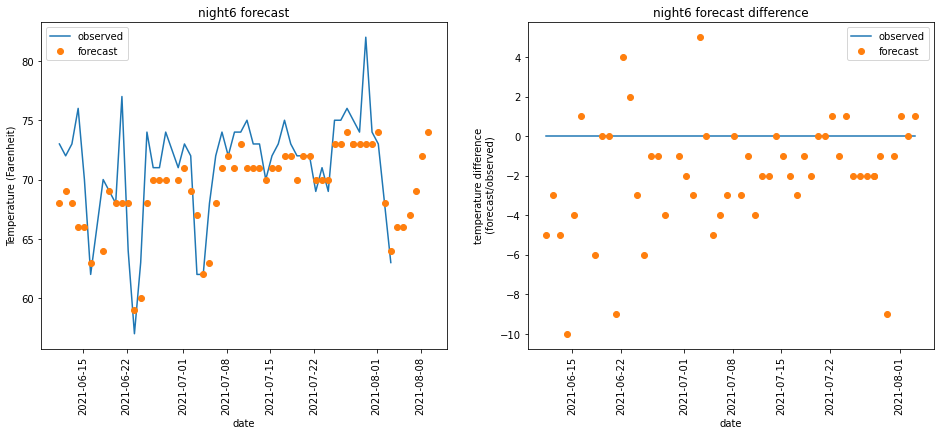

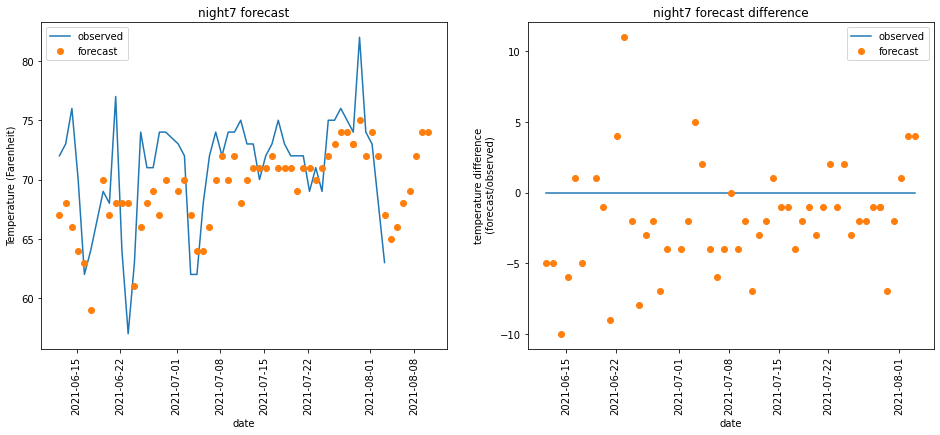

In [16]:
nightList = [night1, night2, night3, night4, night5, night6, night7]

for night in nightList:
    plotForecast(night)

In [17]:
dayName = ['1', '2', '3', '4', '5', '6', '7']

dayStats = pd.DataFrame()
for i in range(len(dayList)):
    df = dayList[i]
    dayStats[dayName[i]] = df['tempDiff'].describe()

dayStats

,1,2,3,4,5,6,7
count,58.000000,57.000000,56.000000,55.000000,54.000000,53.000000,52.000000
mean,-0.310345,-0.684211,-0.875000,-0.545455,-0.148148,-0.433962,-0.961538
std,2.909192,2.958993,3.027525,2.706769,3.140769,3.890370,4.237839
min,-10.000000,-9.000000,-8.000000,-6.000000,-7.000000,-10.000000,-10.000000
25%,-2.000000,-3.000000,-2.250000,-2.000000,-2.000000,-3.000000,-4.000000
50%,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
75%,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000
max,5.000000,6.000000,8.000000,6.000000,8.000000,9.000000,10.000000


In [18]:
nightName = ['1', '2', '3', '4', '5', '6', '7']

nightStats = pd.DataFrame()
for i in range(len(nightList)):
    df = nightList[i]
    nightStats[nightName[i]] = df['tempDiff'].describe()

nightStats

,1,2,3,4,5,6,7
count,58.000000,57.000000,56.000000,55.000000,54.000000,53.000000,52.000000
mean,-1.896552,-1.912281,-2.089286,-2.054545,-1.685185,-1.924528,-1.923077
std,1.723823,2.811207,2.391476,2.599275,2.759711,2.874617,3.792904
min,-7.000000,-15.000000,-9.000000,-9.000000,-8.000000,-10.000000,-10.000000
25%,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-4.000000
50%,-2.000000,-1.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
75%,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,-0.750000
max,2.000000,3.000000,3.000000,6.000000,7.000000,5.000000,11.000000


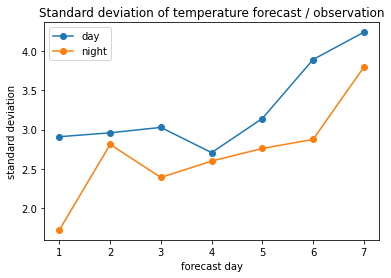

In [19]:
plt.plot(dayStats.loc['std'], marker='o', label='day')
plt.plot(nightStats.loc['std'], marker='o', label='night')
plt.legend()
plt.xlabel('forecast day')
plt.ylabel('standard deviation')
plt.title('Standard deviation of temperature forecast / observation');

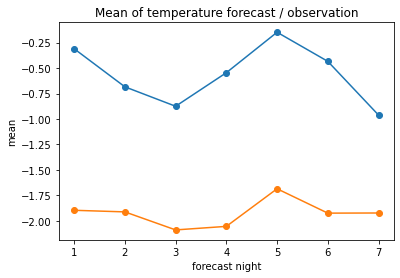

In [20]:
plt.plot(dayStats.loc['mean'], marker='o', label='day')
plt.plot(nightStats.loc['mean'], marker='o')
plt.xlabel('forecast night')
plt.ylabel('mean')
plt.title('Mean of temperature forecast / observation');

In [21]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y


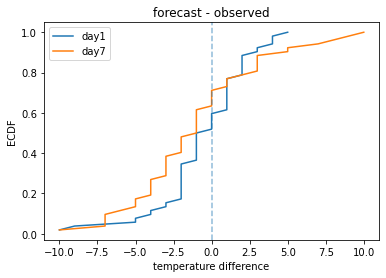

In [22]:
x1, y1 = ecdf(day1['tempDiff'].iloc[:-7])
x7, y7 = ecdf(day7['tempDiff'].iloc[:-7])

plt.plot(x1, y1, label='day1')
plt.plot(x7, y7, label='day7')
plt.axvline(0, linestyle='--', alpha=0.5)
plt.title('forecast - observed')
plt.xlabel('temperature difference')
plt.ylabel('ECDF')
plt.legend();

## Significance testing between temperature differences

The differences between the forecast temperatures and the observed temperatures for different forecast days have different standard deviations. The standard deviations range from ~3 to ~4 from the first forecast day to the last forecast day. The question becomes, is this 1 deg F difference in the standard deviation between the first and last day significant? I use permutations to test the null hypothesis that the standard deviations that the forecast - observed temperatures for the first and last forecast days are the same. 

In [23]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2


def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates


def diff_of_std(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of std of data_1, data_2: diff
    diff = np.std(data_1) - np.std(data_2)

    return diff

In [24]:
input1 = day1['tempDiff'].iloc[:-7]
input2 = day7['tempDiff'].iloc[:-7]

# Compute difference of std 
empirical_diff_std = diff_of_std(input1, input2)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(input1, input2,
                                 diff_of_std, size=10000)

# Compute p-value: p
perm_p = np.sum(perm_replicates <= empirical_diff_std) / len(perm_replicates)

A more traditional statistical test to test the equality of the variance between two or more groups is Levene's test.

In [25]:
from scipy.stats import levene

stat, levene_p = levene(input1, input2)

In [26]:
print('Permutation p-value =', perm_p)
print('Levene test p-value =', levene_p)

Permutation p-value = 0.0146
Levene test p-value = 0.036942611579404296


#### Significance testing results

Both the permutation test and the Levene tests give low p-values for the standard deviation between the forecast and observed temperatures from the first and last forecast days. The low p-values suggest that the temperature forecasts for day 7 are less certain than those for day 1. So when looking at a forecast, you can expect the actual temperature to have a 1s uncertainty of about 3 degrees for the first 5 days, and about 4 degrees for days 6 and 7. 

### Boxplots to visualize the temperature differences for the daytime and nighttime forecasts

As was seen in the plots above, and the summary statistics, the daytime forecasts are pretty accurate on average. However, for the overnight lows, the actual observed temperatures are consistently higher than what is forecast. My hypothesis is that this is an [urban effect](https://en.wikipedia.org/wiki/Urban_heat_island). The weather station where the observations are from is the Nashville International Airport, so the station is likely surrounded by concrete and tarmac, which absorbes heat from the sun during the day, then radiates it back out at night. The forecast air temperatures must not take this extra radiative heat into account, thus the actual observed temperature is higher than what is expected from the forecast. 

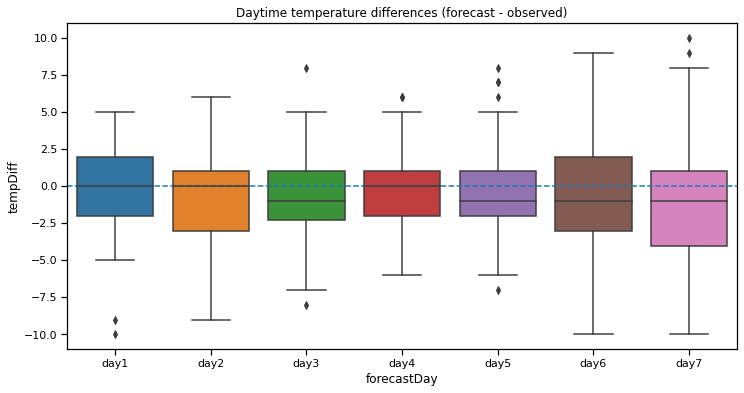

In [27]:
sns.set_context('notebook')

fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x='forecastDay', y='tempDiff', data=forecast_obs[forecast_obs['isDaytime']], ax=ax)
plt.axhline(0, linestyle='--')
plt.title('Daytime temperature differences (forecast - observed)');

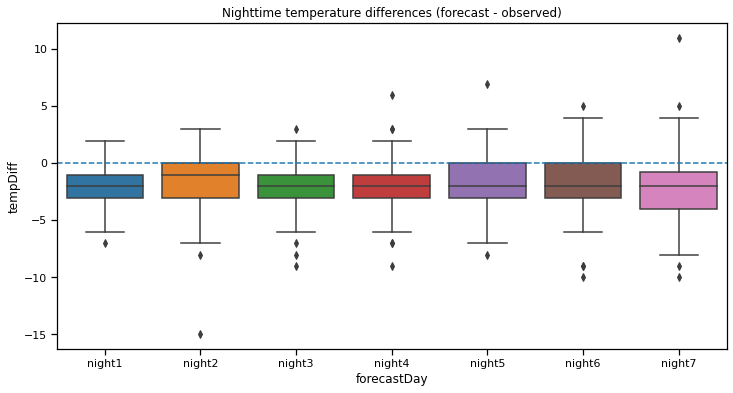

In [28]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x='forecastDay', y='tempDiff', data=forecast_obs[~forecast_obs['isDaytime']], ax=ax)
plt.axhline(0, linestyle='--')
plt.title('Nighttime temperature differences (forecast - observed)');

## Working with rainfall data

Most of the time when I look at the weather, I'm most concerned with if it is going to rain and if so, how much? Here, I take each forecast that predicted a certain percentage of rainfall (from 0 to 100%) and add up all the times it actually rained to calculate the actual percentage of time it rained. If the forecast percent chance of rain is accurate, then over time, it should rain that percentage of time. For example, if over a year there are 20 day3 forecasts of a 50% chance of rain, we would expect that 10 of those 20 days to have some rainfall. 

The Nashville office of National Weather Service only gives a forecast of rainfall amounts for the day1, night1, and day2 forecasts. Here I visualize the actual rainfall relative to the forecasts and calculate the differences. 

In [29]:
# setup lists to iterate over
percentage = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
dfList = [day1, night1, day2, night2, day3, night3, day4,
          night4, day5, night5, day6, night6, day7, night7]
nameList = ['day1', 'night1', 'day2', 'night2', 'day3', 'night3', 'day4',
          'night4', 'day5', 'night5', 'day6', 'night6', 'day7', 'night7']
rainPercentCompare = pd.DataFrame(index=percentage)
rainPercentCounts = pd.DataFrame(index=percentage)
rainCounts = pd.DataFrame(index=percentage)

rainPercent_obs = []
rainCounts1 = []
for i, df in enumerate(dfList):
    for val in percentage:
        # counts of the forecast % rainfall
        counts = df['precip%'].value_counts().sort_index()
        # fill output cell with NaN if no rain was forecast at that percentage
        if (df['precip%'] == val).sum() == 0:
            rainPercent_obs.append(np.nan)
            rainCounts1.append(np.nan)
        else:
            # calculate the actual observed percent rainfall for each forecast percent
            rainPercent_obs.append(100*(df[df['precip%'] == val]['rain?'].sum()/counts[val]))
            # count the number of times it rained for each forecast percent rainfall
            rainCounts1.append(df[df['precip%'] == val]['rain?'].sum())
    
    # build DataFrames of rainfall data for all forecasts
    # the actual observed percent rainfall for each forecast percent
    rainPercentCompare[nameList[i]] = pd.DataFrame(rainPercent_obs, index=percentage)
    # number of times each percent chance of rain was forecast
    rainPercentCounts[nameList[i]] = pd.DataFrame(counts, index=percentage)
    # number of times it actually rained for each forecast percent rainfall
    rainCounts[nameList[i]] = pd.DataFrame(rainCounts1, index=percentage)
    rainPercent_obs = []
    rainCounts1 = []


In [30]:
# number of times each percent chance of rain was forecast
rainPercentCounts

,day1,night1,day2,night2,day3,night3,day4,night4,day5,night5,day6,night6,day7,night7
0,23.0,29.0,21.0,26.0,17.0,18.0,18.0,18.0,15.0,11.0,13.0,12.0,11.0,10.0
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,6.0,4.0,8.0,7.0,10.0,10.0,5.0,5.0,8.0,12.0,7.0,8.0,11.0,11.0
30,3.0,4.0,4.0,4.0,8.0,8.0,11.0,10.0,12.0,13.0,9.0,9.0,7.0,8.0
40,6.0,7.0,3.0,3.0,2.0,4.0,2.0,2.0,3.0,4.0,7.0,10.0,13.0,14.0
50,6.0,9.0,2.0,4.0,3.0,2.0,11.0,13.0,8.0,7.0,15.0,13.0,13.0,12.0
60,6.0,3.0,8.0,11.0,5.0,4.0,4.0,4.0,7.0,8.0,5.0,4.0,4.0,4.0
70,7.0,NaN,10.0,NaN,9.0,9.0,6.0,4.0,4.0,3.0,3.0,3.0,NaN,NaN
80,1.0,1.0,1.0,1.0,5.0,4.0,2.0,3.0,2.0,1.0,NaN,NaN,NaN,NaN
90,1.0,2.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# number of times it actually rained for each forecast percent rainfall
rainCounts

,day1,night1,day2,night2,day3,night3,day4,night4,day5,night5,day6,night6,day7,night7
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,3.0,2.0,1.0,2.0,1.0,1.0
40,2.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,6.0,1.0
50,2.0,1.0,0.0,1.0,1.0,0.0,4.0,4.0,3.0,1.0,4.0,2.0,4.0,2.0
60,3.0,2.0,3.0,5.0,1.0,2.0,2.0,1.0,5.0,2.0,2.0,0.0,0.0,1.0
70,2.0,NaN,5.0,NaN,4.0,2.0,4.0,2.0,1.0,1.0,1.0,1.0,NaN,NaN
80,1.0,1.0,1.0,0.0,3.0,2.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN
90,1.0,2.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Trying to create bootstrap rainfall counts

Testing whether the observed counts for each forecast chance of rain could match the forecast chance of rain

Not sure this is going to work or if it is worth it...

In [32]:
# test = number1[number1['rain?']]['precip%']

# test1 = []
# test_df = pd.DataFrame()
# testCounts = pd.DataFrame()

# for i in range(1000):
#     test1.append(np.random.choice(test, size=len(test)))
#     test_df = pd.DataFrame(test1).T
#     testCounts[i] = test_df[i].value_counts().sort_index()

# testCounts.mean(axis=1)

In [33]:
# the actual observed percent rainfall for each forecast percent
rainPercentCompare

,day1,night1,day2,night2,day3,night3,day4,night4,day5,night5,day6,night6,day7,night7
0,0.000000,0.000000,0.000000,0.000000,5.882353,5.555556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30,33.333333,25.000000,25.000000,0.000000,12.500000,0.000000,18.181818,0.000000,25.000000,15.384615,11.111111,22.222222,14.285714,12.500000
40,33.333333,28.571429,33.333333,0.000000,50.000000,25.000000,0.000000,0.000000,0.000000,0.000000,28.571429,10.000000,46.153846,7.142857
50,33.333333,11.111111,0.000000,25.000000,33.333333,0.000000,36.363636,30.769231,37.500000,14.285714,26.666667,15.384615,30.769231,16.666667
60,50.000000,66.666667,37.500000,45.454545,20.000000,50.000000,50.000000,25.000000,71.428571,25.000000,40.000000,0.000000,0.000000,25.000000
70,28.571429,NaN,50.000000,NaN,44.444444,22.222222,66.666667,50.000000,25.000000,33.333333,33.333333,33.333333,NaN,NaN
80,100.000000,100.000000,100.000000,0.000000,60.000000,50.000000,50.000000,66.666667,50.000000,100.000000,NaN,NaN,NaN,NaN
90,100.000000,100.000000,0.000000,66.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
rainPercentCompare['day1'] - rainPercentCompare.index

0       0.000000
10           NaN
20    -20.000000
30      3.333333
40     -6.666667
50    -16.666667
60    -10.000000
70    -41.428571
80     20.000000
90     10.000000
100          NaN
dtype: float64

In [35]:
rainPercentDiff = pd.DataFrame()
for column in rainPercentCompare:
    rainPercentDiff[column] = rainPercentCompare[column] - rainPercentCompare.index

In [36]:
rainPercentDiff

,day1,night1,day2,night2,day3,night3,day4,night4,day5,night5,day6,night6,day7,night7
0,0.000000,0.000000,0.000000,0.000000,5.882353,5.555556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000,-20.000000
30,3.333333,-5.000000,-5.000000,-30.000000,-17.500000,-30.000000,-11.818182,-30.000000,-5.000000,-14.615385,-18.888889,-7.777778,-15.714286,-17.500000
40,-6.666667,-11.428571,-6.666667,-40.000000,10.000000,-15.000000,-40.000000,-40.000000,-40.000000,-40.000000,-11.428571,-30.000000,6.153846,-32.857143
50,-16.666667,-38.888889,-50.000000,-25.000000,-16.666667,-50.000000,-13.636364,-19.230769,-12.500000,-35.714286,-23.333333,-34.615385,-19.230769,-33.333333
60,-10.000000,6.666667,-22.500000,-14.545455,-40.000000,-10.000000,-10.000000,-35.000000,11.428571,-35.000000,-20.000000,-60.000000,-60.000000,-35.000000
70,-41.428571,NaN,-20.000000,NaN,-25.555556,-47.777778,-3.333333,-20.000000,-45.000000,-36.666667,-36.666667,-36.666667,NaN,NaN
80,20.000000,20.000000,20.000000,-80.000000,-20.000000,-30.000000,-30.000000,-13.333333,-30.000000,20.000000,NaN,NaN,NaN,NaN
90,10.000000,10.000000,-90.000000,-23.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
rainPercentCompare_T = rainPercentCompare.T
rainPercentCompare_T

,0,10,20,30,40,50,60,70,80,90,100
day1,0.000000,NaN,0.0,33.333333,33.333333,33.333333,50.000000,28.571429,100.000000,100.000000,NaN
night1,0.000000,NaN,0.0,25.000000,28.571429,11.111111,66.666667,NaN,100.000000,100.000000,NaN
day2,0.000000,NaN,0.0,25.000000,33.333333,0.000000,37.500000,50.000000,100.000000,0.000000,100.0
night2,0.000000,NaN,0.0,0.000000,0.000000,25.000000,45.454545,NaN,0.000000,66.666667,NaN
day3,5.882353,NaN,0.0,12.500000,50.000000,33.333333,20.000000,44.444444,60.000000,NaN,NaN
night3,5.555556,NaN,0.0,0.000000,25.000000,0.000000,50.000000,22.222222,50.000000,NaN,NaN
day4,0.000000,NaN,0.0,18.181818,0.000000,36.363636,50.000000,66.666667,50.000000,NaN,NaN
night4,0.000000,NaN,0.0,0.000000,0.000000,30.769231,25.000000,50.000000,66.666667,NaN,NaN
day5,0.000000,NaN,0.0,25.000000,0.000000,37.500000,71.428571,25.000000,50.000000,NaN,NaN
night5,0.000000,NaN,0.0,15.384615,0.000000,14.285714,25.000000,33.333333,100.000000,NaN,NaN


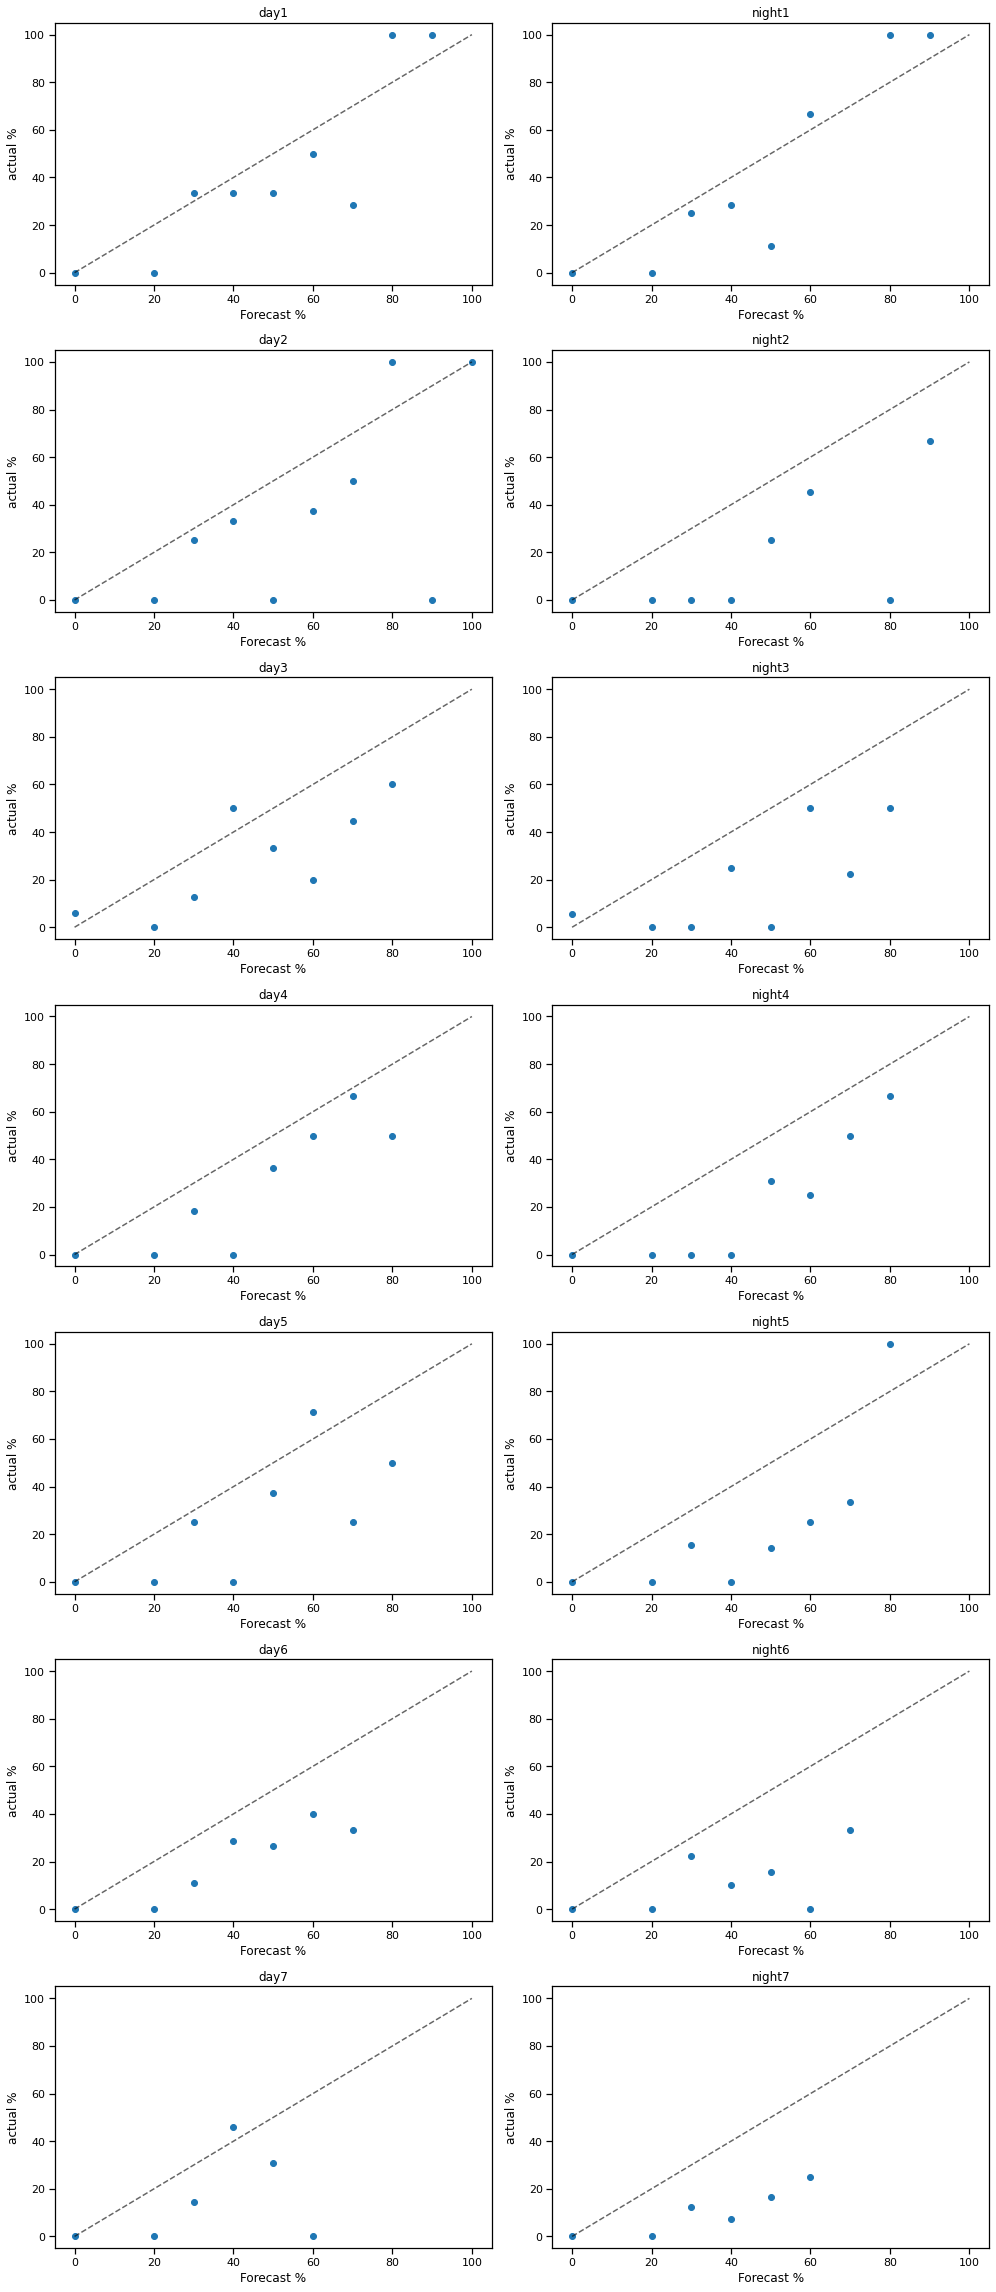

In [38]:
plt.subplots(figsize=(14,32))
for i in range(len(nameList)):
    plt.subplot(7,2,i+1)
    plt.scatter(rainPercentCompare.index, rainPercentCompare[nameList[i]])
    plt.plot([0,100], [0, 100], '--', color='k', alpha=0.6)
    ax.margins(0.2)
    plt.xlabel('Forecast %')
    plt.ylabel('actual %')
    plt.title(nameList[i])
    plt.tight_layout()

In [39]:
forecast_obs.columns

Index(['detailedForecast', 'endTime', 'icon', 'isDaytime', 'name', 'number',
       'shortForecast', 'startTime', 'temperature', 'temperatureTrend',
       'temperatureUnit', 'windDirection', 'windSpeed', 'precip%',
       'windSpeedMin', 'windSpeedMax', 'retrievalDate', 'forecastDay',
       'rain low', 'rain high', 'value', 'AirTemp_obs', 'Dwpt_obs',
       'HeatIndex_obs', 'Precip_obs', 'windDir_obs', 'windSpeed_obs',
       'tempDiff', 'rainLowDiff', 'rainHighDiff', 'windLowDiff',
       'windHighDiff', 'rain?'],
      dtype='object')

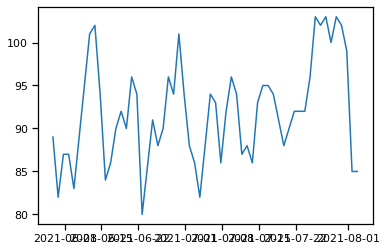

In [40]:
plt.plot(day1['endTime'], day1['HeatIndex_obs'])

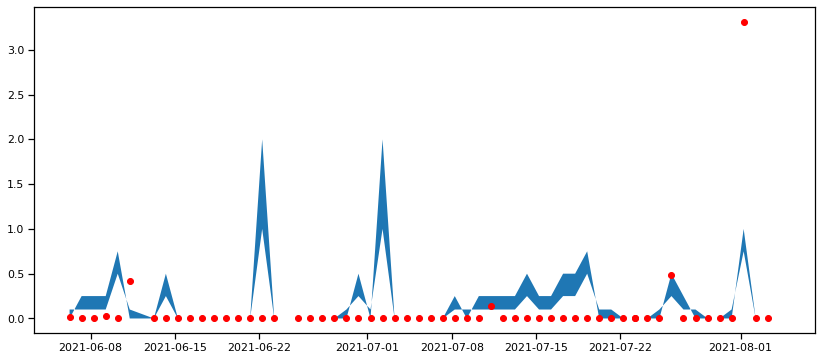

In [41]:
plt.subplots(figsize=(14,6))
plt.fill_between(night1['endTime'], night1['rain low'], night1['rain high'])
plt.plot(night1['endTime'], night1['Precip_obs'], marker='o', linestyle='None', color='red')